In [1]:
import requests
import json
import pandas as pd
import datetime 
from datetime import datetime as dt
import pytz
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re


# What is this:
This is an ongoing study notebook for the construction of the Github Activit Lego. It is using GR15 applicants dataset to start the study and will incorporate past rounds to enhance the study base. 

# Some highlights from the exploratory analysis till now
:

- 88% of the grants on the dataset were approved  
  
  
- From the 403 projects, 259 had github urls but only 99 of them had url that direct to a repository, others have urls to their personal profile on organization profile. ( therefore are not available to be analyzed here given API restrictions)   

  
-  80% of these repos still exists , 18% does not anymore and 2% are empty repos.  

 
- Here are the summary of the status of these repos given their approval to the round:     
    - 200 = still exists  / 404 = does not exist anymore  / 204 = empty repos  
 

In [139]:
#git_compare.groupby('extract_status_code').agg({'approved' : 'value_counts'})

approved
extract_status_code approved          
200                 True            78
                    False            5
204                 True             2
404                 True            18
                    False            1

### analysis given time and existence of repo:  



6 month ealier number of non_existent projects = 73%  
3 month ealier number of non_existent projects = 39%  
1 month ealier number of non_existent projects = 4%  

*gr15 start date : 07-09-2022

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


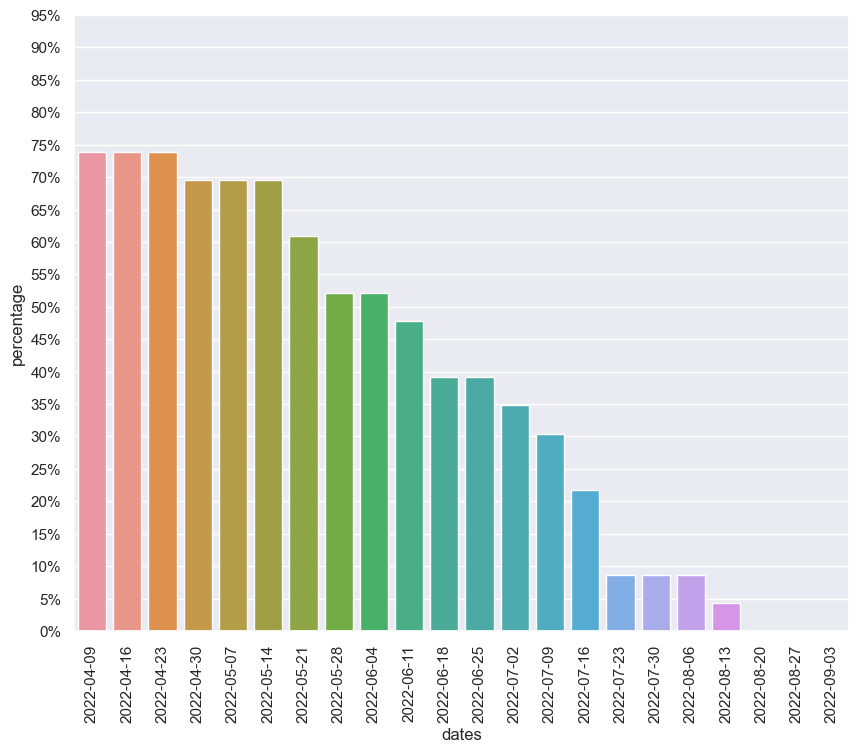

In [198]:
# sns.set(rc={'figure.figsize':(10,8)})
# graph2 = sns.barplot(act_data_nan.drop(index=[24,23,22])['dates'],act_data_nan.drop(index=[24,23,22])['percentage'])

# graph2.set_xticklabels(graph2.get_xticklabels(), rotation=90)
# tick_positions = range(0,100,5)
# tick_labels = [str(i) + "%" for i in tick_positions]
# plt.yticks(tick_positions, tick_labels)
# plt.show()

# The analysis: 

## functions

In [4]:
def get_owner_repo(github_urls):

    owner = []
    repo = []
    url = []

    for i in github_urls:
        matches = re.search(r"github\.com\/([\w\-\.]+)\/([\w\-\.]+)", i)
        if matches:
            username = matches.group(1)
            repository_name = matches.group(2)
            url.append(i)
            owner.append(username)
            repo.append(repository_name)
        else:
            matches = re.search(r"github\.com\/([\w\-\.]+)", i)
            if matches:
                owner_name = matches.group(1)
                url.append(i)
                owner.append(owner_name)
                repo.append(None)
            else:
                url.append(i)
                owner.append(None)
                repo.append(None)

    github_owner_repo = pd.DataFrame(data= {'url': url, 'owner': owner, 'repo': repo})
    return github_owner_repo
#--------------------------------------------

def sunday_timestamp(week_number, year):
    # Create a datetime object for the first day of the given year
    first_day = datetime.datetime(year, 1, 1, tzinfo=pytz.utc)
    
    # Calculate the number of days to the first Sunday of the year
    days_to_first_sunday = (6 - first_day.weekday()) % 7
    
    # Calculate the number of days to the Sunday of the given week
    days_to_sunday = (week_number - 1) * 7 + days_to_first_sunday
    
    # Create a datetime object for the Sunday of the given week
    sunday = first_day + datetime.timedelta(days=days_to_sunday)
    
    # Convert the datetime object to a UTC timestamp
    return int(sunday.timestamp())

## ------------------------
def timeframing_data(repo_data, start_date_aggregation, end_date_aggregation, year_to_start, year_to_finish):
    weeks = []
    addition = []
    deletions = []
    
    
    for i in range(0,len(repo_data)-1):
       
        weeks.append(json.loads(valid_git_data['repo_data'][i])[0][0])
        addition.append(json.loads(valid_git_data['repo_data'][i])[0][1])
        deletions.append(json.loads(valid_git_data['repo_data'][i])[0][2])


    week_addition = pd.DataFrame( data = [weeks, addition, deletions]).T

    week_addition.columns = ['weeks', 'addition', 'deletions']

    additions_by_week = week_addition[(week_addition['weeks']<= sunday_timestamp(start_date_aggregation,year_to_start)) & 
                  (week_addition['weeks'] > (sunday_timestamp(start_date_aggregation,year_to_finish) - end_date_aggregation* 604800 ))]
    
    return additions_by_week


#--------------------------------------------
# receives df with repo name, owner, url and json of the data and spits two df, addtions by url and deletions by url given a timeframe
def tretened_df(raw_git_data, start_date_aggregation, end_date_aggregation, year_to_start,year_to_finish ):

    addtions_df  = pd.DataFrame([])


    deletions_df  = pd.DataFrame([])

    valid_git_data = raw_git_data[raw_git_data['extract_status_code'] == 200]
    valid_git_data.reset_index(drop = True, inplace = True)
    
    for i in range(0,len(valid_git_data['repo_data'])-1):
        timeframed_df = timeframing_data(valid_git_data['repo_data'][i], 
                                         start_date_aggregation, 

                                        end_date_aggregation, 
                                         year_to_start , 
                                         year_to_finish )

        ad_df = timeframed_df[['weeks','addition']].T
        ad_df.columns=ad_df.iloc[0] 
        ad_df.drop(labels='weeks', inplace = True)
        ad_df.rename(index = {'addition' :valid_git_data.index[i]}, inplace = True)
        addtions_df= pd.concat([addtions_df, ad_df])

        del_df = timeframed_df[['weeks','deletions']].T
        del_df.columns=del_df.iloc[0] 
        del_df.drop(labels='weeks', inplace = True)
        del_df.rename(index = {'deletions' :valid_git_data.index[i]}, inplace = True)
        deletions_df= pd.concat([deletions_df, del_df])

    return addtions_df , deletions_df

In [5]:
grants = pd.read_excel('gr15_grants.xlsx')

gr_aplic = pd.read_json('grants_applications_gr15.json').T

df  = gr_aplic.merge(grants, on = 'grant_id' )

In [6]:
df.columns

Index(['grant_id', 'active_x', 'approved', 'address_x', 'title_x', 'url',
       'description_x', 'created_on_x', 'active_y', 'title_y', 'address_y',
       'amount_received', 'amount_received_in_round', 'contribution_count',
       'contributor_count', 'description_y', 'website', 'github_project_url',
       'twitter_handle_2', 'twitter_handle_1', 'twitter_verified',
       'created_on_y', 'last_update'],
      dtype='object')

In [7]:
df['github_project_url'].shape

(403,)

In [8]:
valid_repo_urls = df['github_project_url'].copy()
valid_repo_urls = valid_repo_urls[~valid_repo_urls.isna()]

In [9]:
valid_repo_urls.shape

(259,)

In [10]:
valid_repo_urls = get_owner_repo(valid_repo_urls)

In [11]:
valid_repo_urls = valid_repo_urls[~valid_repo_urls['repo'].isna()]
valid_repo_urls = valid_repo_urls[valid_repo_urls['repo'] != '']
valid_repo_urls = valid_repo_urls.drop(valid_repo_urls[valid_repo_urls.duplicated()].index)
valid_repo_urls.reset_index(drop = True, inplace = True)


In [12]:
valid_repo_urls.shape

(99, 3)

In [13]:
valid_repo_urls

,url,owner,repo
0,https://github.com/socathie/zkML,socathie,zkML
1,https://github.com/DIMCHERRY/NFT-Ads,DIMCHERRY,NFT-Ads
2,https://github.com/SaveWithBuckets/Buckets_v1,SaveWithBuckets,Buckets_v1
3,https://github.com/pshdev0/dexode,pshdev0,dexode
4,https://github.com/AthanorLabs/atomic-swap,AthanorLabs,atomic-swap
...,...,...,...
94,https://github.com/jackalopeio/bonsai,jackalopeio,bonsai
95,https://github.com/Soptq/forta-bot-umbra,Soptq,forta-bot-umbra
96,https://github.com/raycast/extensions/tree/mai...,raycast,extensions
97,https://github.com/efdevcon/DIPs/blob/master/D...,efdevcon,DIPs


#### 88% of the grants were approved

In [15]:
df[['approved']].sum() / df[['title_x', 'approved']].shape[0]

approved    0.885856
dtype: object

In [16]:
# importing data github data 

In [17]:
raw_git_data = pd.read_csv('raw_git_data.csv')

# study df

In [18]:
raw_git_data.head()

,Unnamed: 0,url,owner,repo,extract_status_code,repo_data
0,0,https://github.com/socathie/zkML,socathie,zkML,200,"[[1653782400, 70916, -188], [1654387200, 162, ..."
1,1,https://github.com/DIMCHERRY/NFT-Ads,DIMCHERRY,NFT-Ads,404,"{'message': 'Not Found', 'documentation_url': ..."
2,2,https://github.com/SaveWithBuckets/Buckets_v1,SaveWithBuckets,Buckets_v1,404,"{'message': 'Not Found', 'documentation_url': ..."
3,3,https://github.com/pshdev0/dexode,pshdev0,dexode,404,"{'message': 'Not Found', 'documentation_url': ..."
4,4,https://github.com/AthanorLabs/atomic-swap,AthanorLabs,atomic-swap,200,"[[1634428800, 140425, -134039], [1635033600, 4..."


In [19]:
raw_git_data.shape

(100, 6)

In [20]:
raw_git_data['extract_status_code'].value_counts(normalize = True)

200    0.80
404    0.18
204    0.02
Name: extract_status_code, dtype: float64

In [21]:
git_compare = raw_git_data.copy()
git_compare.set_index('url', inplace = True)

df_compare = df[['github_project_url','approved']].copy()
df_compare = df_compare.rename(columns = {'github_project_url': 'url'})
df_compare = df_compare.set_index('url')
git_compare = git_compare.join(df_compare)

In [22]:
git_compare.columns

Index(['Unnamed: 0', 'owner', 'repo', 'extract_status_code', 'repo_data',
       'approved'],
      dtype='object')

In [23]:
git_compare.drop(git_compare[git_compare.duplicated()].index, inplace =True)

In [24]:
git_compare.shape

(96, 6)

In [179]:
git_compare.to_csv('GR15_github_activity.csv')

In [139]:
git_compare.groupby('extract_status_code').agg({'approved' : 'value_counts'})

approved
extract_status_code approved          
200                 True            78
                    False            5
204                 True             2
404                 True            18
                    False            1

In [144]:
valid_git_data  = git_compare[git_compare['extract_status_code'] == 200]
valid_git_data.reset_index(inplace =True)

In [145]:
valid_git_data

,url,owner,repo,extract_status_code,repo_data,approved
0,https://github.com/0xperp/defi_greeks,0xperp,defi_greeks,200,"[[1650153600, 984, -16], [1650758400, 0, 0], [...",True
1,https://github.com/3numdao/Signal-Desktop,3numdao,Signal-Desktop,200,"[[1388880000, 4066, -159], [1389484800, 912, -...",False
2,https://github.com/4metaverse/bookswap-unstopp...,4metaverse,bookswap-unstoppable-domain,200,"[[1661040000, 60636, 0], [1661644800, 118, 0],...",True
3,https://github.com/ActiveInferenceInstitute/Ac...,ActiveInferenceInstitute,ActiveBlockference,200,"[[1644710400, 4204, -1794], [1645315200, 3182,...",True
4,https://github.com/ActiveInferenceInstitute/Ac...,ActiveInferenceInstitute,ActiveBlockference,200,"[[1644710400, 4204, -1794], [1645315200, 3182,...",True
...,...,...,...,...,...,...
78,https://github.com/velarxneo/realms-react,velarxneo,realms-react,200,"[[1637452800, 4028, -234], [1638057600, 0, 0],...",True
79,https://github.com/walliDprotocol/WalliD-Wallet,walliDprotocol,WalliD-Wallet,200,"[[1658016000, 1, 0], [1658620800, 0, 0], [1659...",True
80,https://github.com/wonderwomancode/web3-art-wo...,wonderwomancode,web3-art-workshop,200,"[[1661644800, 2, 0], [1662249600, 0, 0], [1662...",True
81,https://github.com/zepedrotrigo/zklands,zepedrotrigo,zklands,200,"[[1648944000, 28736, -240], [1649548800, 1668,...",True


# non-existent projects and time

In [159]:
act_data.isna().sum().reset_index().columns

Index(['index', 0], dtype='object')

In [177]:
act_data_nan = act_data.isna().sum().reset_index().rename(columns = {'index': 'dates', 0 : 'not_existent'})

In [184]:
act_data_nan.drop(index = 25, inplace = True) # fazer aqui interativo pra ser o ultimo sempre, pode dar merda se eu trocar

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


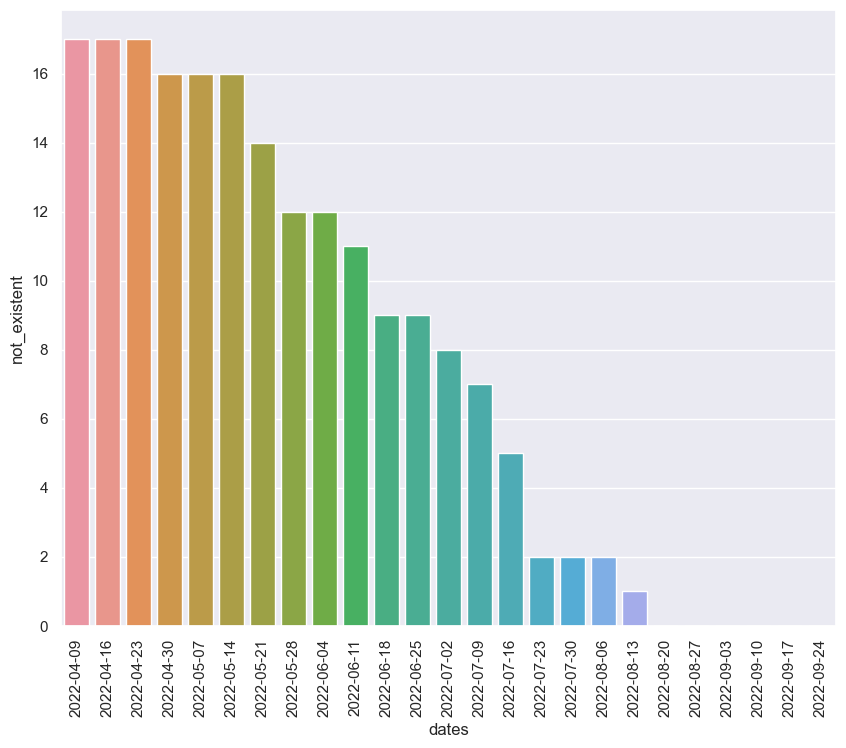

In [188]:
sns.set(rc={'figure.figsize':(10,8)})
graph1 = sns.barplot(act_data_nan['dates'],act_data_nan['not_existent'])

graph1.set_xticklabels(graph1.get_xticklabels(), rotation=90)
plt.show()

In [189]:
act_data_nan['percentage'] = act_data_nan['not_existent'] / 23 * 100

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


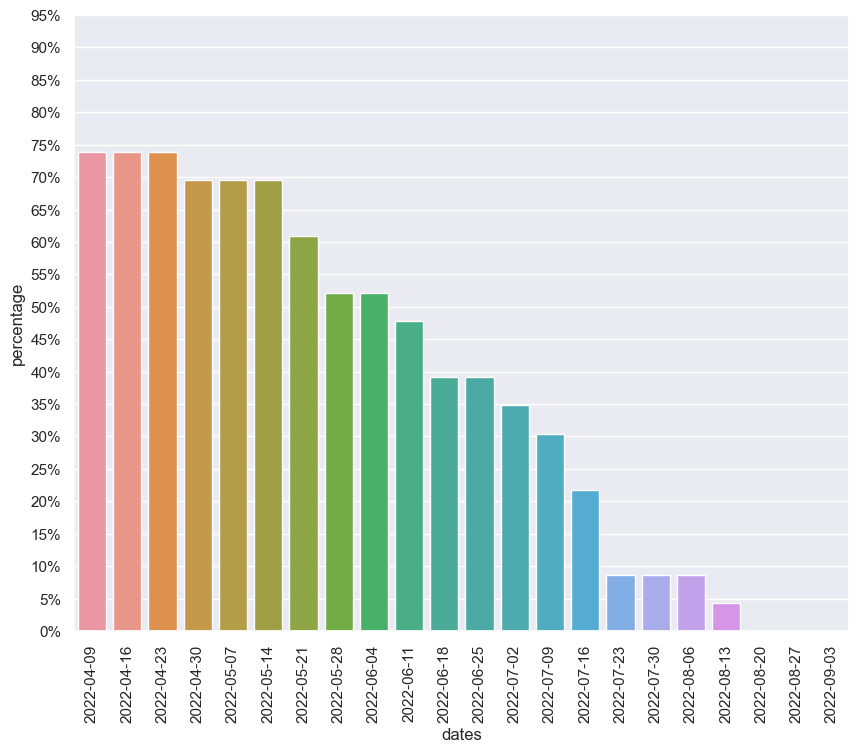

In [198]:
sns.set(rc={'figure.figsize':(10,8)})
graph2 = sns.barplot(act_data_nan.drop(index=[24,23,22])['dates'],act_data_nan.drop(index=[24,23,22])['percentage'])

graph2.set_xticklabels(graph2.get_xticklabels(), rotation=90)
tick_positions = range(0,100,5)
tick_labels = [str(i) + "%" for i in tick_positions]
plt.yticks(tick_positions, tick_labels)
plt.show()